# Checking Python Version (Must be less than 3.10 to support tensorflow)

In [ ]:
!python --version

Python 3.12.11


# Install the used libraries

In [ ]:
!pip install datasets
!pip install tensorflow
!pip install contractions
!pip install textblob
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 12.0 MB/s eta 0:00:00


# Part 1 : Data Preprocessing and Baseline Modeling

### Loading the dataset

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")
train_data = dataset['train']
test_data = dataset['test']  # <-- added test split
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Preprocessing the dataset

In [ ]:
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from contractions import fix
# pip install textblob
from textblob import Word



# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Pre-compile regex patterns
URL_PATTERN = re.compile(r"http\S+")
USER_PATTERN = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#\w+")
SPECIAL_CHARS = re.compile(r"[^\w\s]")  # Removes punctuation, keeps digits
NUM_PATTERN = re.compile(r"\d+")
ELONGATED_PATTERN = re.compile(r'(.)\1{2,}', re.DOTALL)  # e.g., soooo → soo

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Expand contractions
    text = fix(text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, user mentions, hashtags
    text = URL_PATTERN.sub('', text)
    text = USER_PATTERN.sub('', text)
    text = HASHTAG_PATTERN.sub('', text)

    # Demojize emojis (😊 -> :smile_face:)
    text = emoji.demojize(text)

    # Normalize elongated words
    text = ELONGATED_PATTERN.sub(r'\1\1', text)  # soooo → soo

    # Replace numbers with <NUM> token
    text = NUM_PATTERN.sub(' <NUM> ', text)

    # Remove special characters
    text = SPECIAL_CHARS.sub(' ', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Lemmatize and remove stopwords
    tokens = [
        lemmatizer.lemmatize(word) for word in tokens
        if word not in stop_words and len(word) > 2
    ]
    #tokens = [Word(word).correct() for word in tokens] will try it so slow.

    return " ".join(tokens)


# Apply cleaning
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Exploratory data analysis (EDA)

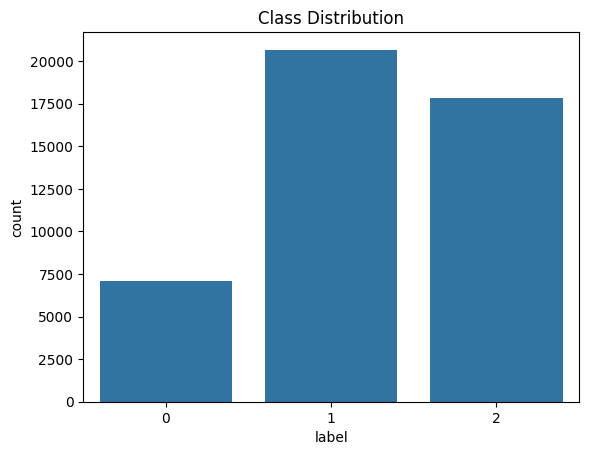

Most common words for label 0: [('NUM', 5547), ('not', 2282), ('may', 1574), ('tomorrow', 932), ('like', 599), ('going', 579), ('day', 498), ('get', 423), ('time', 388), ('want', 348)]
Most common words for label 1: [('NUM', 21581), ('tomorrow', 2942), ('may', 2903), ('not', 2853), ('going', 1634), ('day', 1485), ('night', 1330), ('sunday', 1235), ('friday', 1210), ('time', 1170)]
Most common words for label 2: [('NUM', 15269), ('tomorrow', 3530), ('day', 2270), ('may', 2205), ('not', 2132), ('going', 1657), ('see', 1576), ('night', 1509), ('friday', 1259), ('time', 1161)]


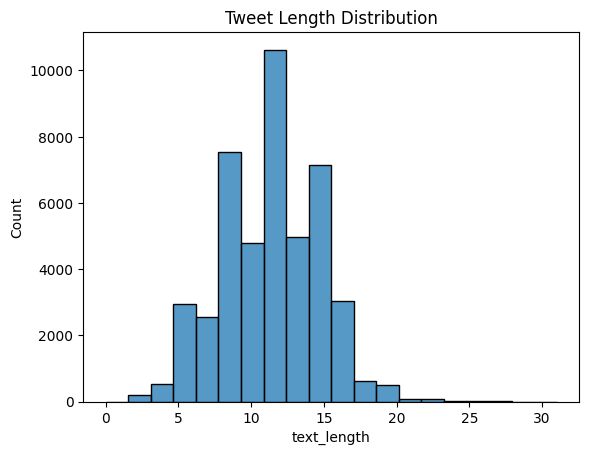

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Class distribution
sns.countplot(x=df_train['label'])
plt.title("Class Distribution")
plt.show()

# Most frequent words per class
for label in [0, 1, 2]:  # 0: Negative, 1: Neutral, 2: Positive
    words = " ".join(df_train[df_train['label'] == label]['clean_text']).split()
    common_words = Counter(words).most_common(10)
    print(f"Most common words for label {label}: {common_words}")

# Tweet length
df_train['text_length'] = df_train['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df_train['text_length'], bins=20)
plt.title("Tweet Length Distribution")
plt.show()

### Tokenization and Padding

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np


# Split train into train + validation (optional)
X_train, X_val, y_train, y_val = train_test_split(
    df_train['clean_text'], df_train['label'], test_size=0.2, random_state=42
)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

vocab_size = min(len(tokenizer.word_index) + 1, 10000)
embedding_dim = 100

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(df_test['clean_text'])  # <-- tokenizing test set

# Pad sequences using 90th percentile length
lengths = [len(seq) for seq in X_train_seq]
max_length = int(np.percentile(lengths, 90))
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')  # <-- padded test set

# One-hot labels
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(df_test['label'], num_classes=3)  # <-- one-hot test labels

In [ ]:
def test_model(model, X_test, y_test_cat, class_names=['Negative','Neutral','Positive']):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Data)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print("Classification Report on Test Data:")
    print(classification_report(y_true, y_pred, digits=4, target_names=class_names))

### RNN Based Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,012,739 (3.86 MB)

 Trainable params: 1,012,739 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5376 - loss: 0.9281 - val_accuracy: 0.6329 - val_loss: 0.7936
Epoch 2/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7276 - loss: 0.6409 - val_accuracy: 0.6374 - val_loss: 0.7984
Epoch 3/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.8516 - loss: 0.3903 - val_accuracy: 0.6067 - val_loss: 0.9764
Epoch 4/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9233 - loss: 0.2146 - val_accuracy: 0.5986 - val_loss: 1.2022
Epoch 5/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9566 - loss: 0.1279 - val_accuracy: 0.5797 - val_loss: 1.4027
Epoch 6/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9703 - loss: 0.0882 - val_accuracy: 0.5699 - val_loss: 1.6444
Epoch 7/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9756 - loss: 0.0712 - val_accuracy: 0.5906 - val_loss: 1.8446
Epoch 8/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9773 -

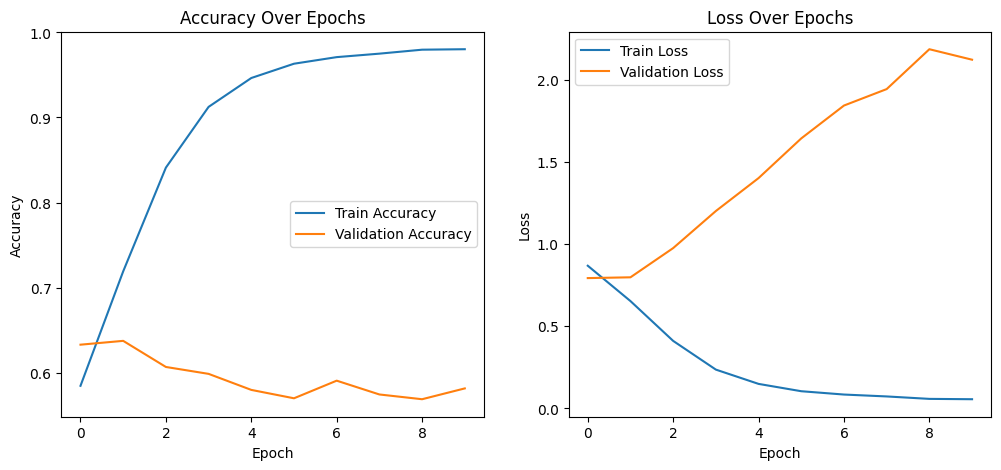

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


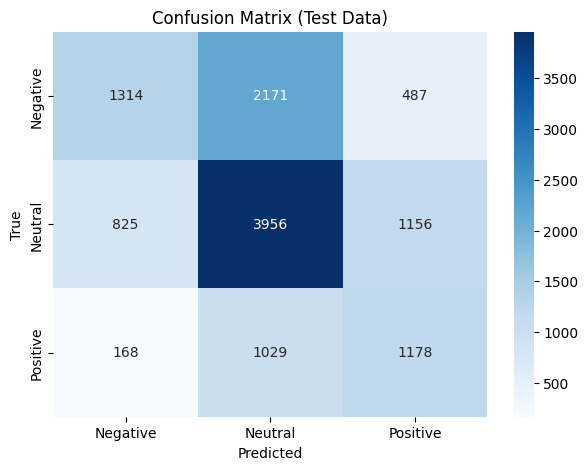

Classification Report on Test Data:
              precision    recall  f1-score   support

    Negative     0.5696    0.3308    0.4185      3972
     Neutral     0.5528    0.6663    0.6043      5937
    Positive     0.4176    0.4960    0.4534      2375

    accuracy                         0.5249     12284
   macro avg     0.5133    0.4977    0.4921     12284
weighted avg     0.5321    0.5249    0.5151     12284



In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Defining the RNN model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(64),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
rnn_model.build(input_shape=(None, max_length))
rnn_model.summary()


history_rnn = rnn_model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val_cat),  # <-- use val set for monitoring
    verbose=1
)

# Plot Training Curves
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate on test set
test_model(rnn_model, X_test_pad, y_test_cat)  # <-- test evaluation

### Feed Forward Based Model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 15, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,200,579 (4.58 MB)

 Trainable params: 1,200,579 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5403 - loss: 0.9137 - val_accuracy: 0.6473 - val_loss: 0.7615
Epoch 2/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.7821 - loss: 0.5266 - val_accuracy: 0.6290 - val_loss: 0.8653
Epoch 3/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9205 - loss: 0.2110 - val_accuracy: 0.5929 - val_loss: 1.2697
Epoch 4/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9678 - loss: 0.0949 - val_accuracy: 0.5978 - val_loss: 1.8912
Epoch 5/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9806 - loss: 0.0555 - val_accuracy: 0.5895 - val_loss: 2.3203
Epoch 6/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9877 - loss: 0.0347 - val_accuracy: 0.5876 - val_loss: 2.4383
Epoch 7/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9898 - loss: 0.0296 - val_accuracy: 0.5777 - val_loss: 3.0404
Epoch 8/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9892 -

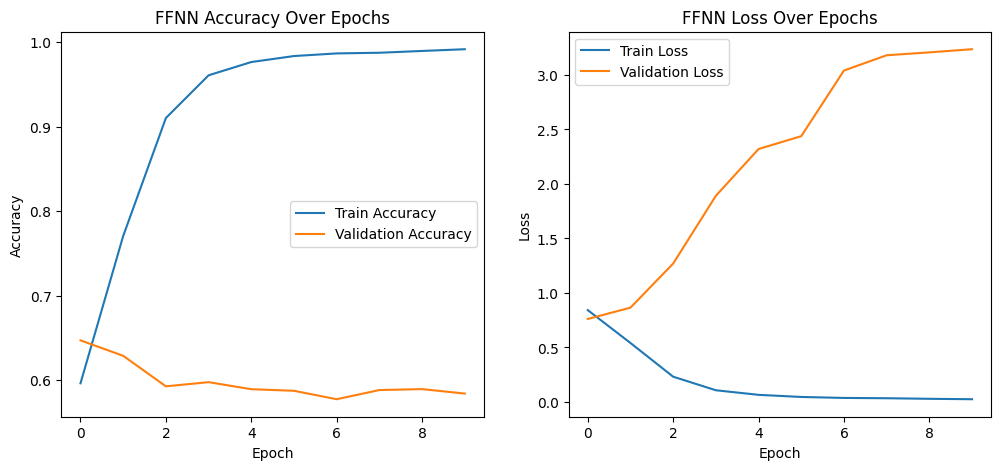

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


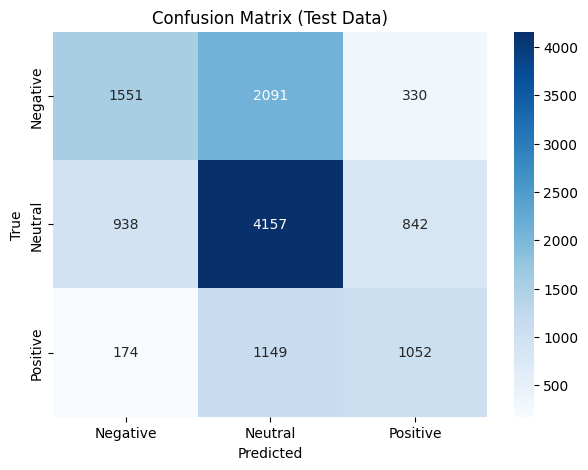

Classification Report on Test Data:
              precision    recall  f1-score   support

    Negative     0.5824    0.3905    0.4675      3972
     Neutral     0.5620    0.7002    0.6235      5937
    Positive     0.4730    0.4429    0.4575      2375

    accuracy                         0.5503     12284
   macro avg     0.5391    0.5112    0.5162     12284
weighted avg     0.5514    0.5503    0.5410     12284



In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Defining the Feed Forward model
ffnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Flatten(),                             # Flatten the embeddings into a 1D vector
    Dense(128, activation='relu'),          # Hidden layer 1
    Dense(64, activation='relu'),           # Hidden layer 2 (optional but helps)
    Dense(3, activation='softmax')           # Output layer (3 classes)
])

ffnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Building the model
ffnn_model.build(input_shape=(None, max_length))
ffnn_model.summary()

history_ffnn = ffnn_model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1
)


# Plot Training Curves
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history_ffnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_ffnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('FFNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history_ffnn.history['loss'], label='Train Loss')
plt.plot(history_ffnn.history['val_loss'], label='Validation Loss')
plt.title('FFNN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


test_model(ffnn_model, X_test_pad, y_test_cat)

### LSTM Based Model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 15, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,044,419 (3.98 MB)

 Trainable params: 1,044,419 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.5509 - loss: 0.9066 - val_accuracy: 0.6544 - val_loss: 0.7560
Epoch 2/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.7110 - loss: 0.6577 - val_accuracy: 0.6499 - val_loss: 0.7716
Epoch 3/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.7540 - loss: 0.5691 - val_accuracy: 0.6473 - val_loss: 0.8183
Epoch 4/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.8011 - loss: 0.4674 - val_accuracy: 0.6364 - val_loss: 0.9009
Epoch 5/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.8380 - loss: 0.3743 - val_accuracy: 0.6327 - val_loss: 1.0919
Epoch 6/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.8722 - loss: 0.2924 - val_accuracy: 0.6235 - val_loss: 1.2677
Epoch 7/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.8993 - loss: 0.2353 - val_accuracy: 0.6141 - val_loss: 1.5673
Epoch 8/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9194 -

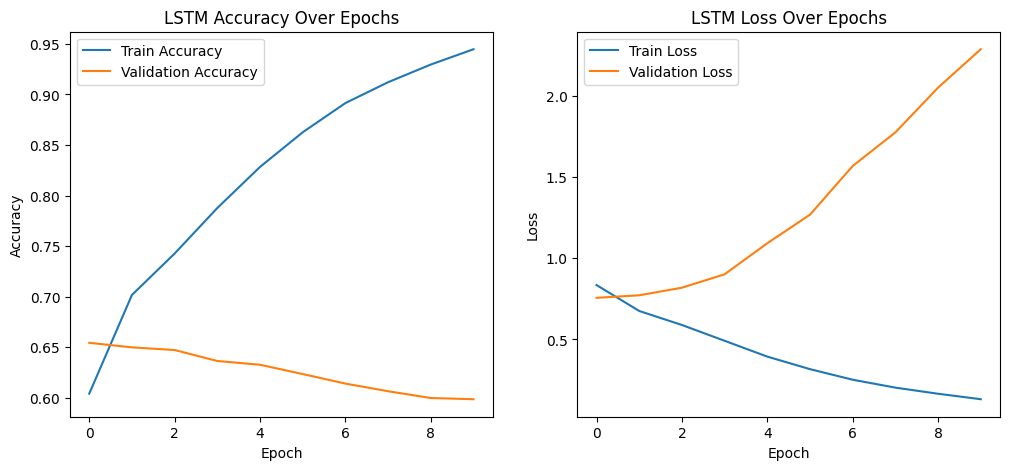

384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


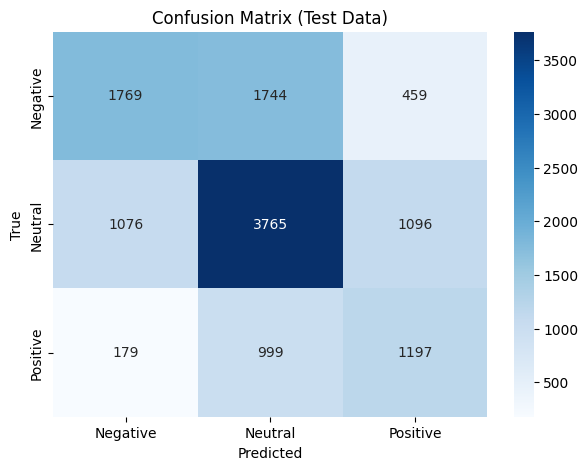

Classification Report on Test Data:
              precision    recall  f1-score   support

    Negative     0.5850    0.4454    0.5057      3972
     Neutral     0.5785    0.6342    0.6051      5937
    Positive     0.4350    0.5040    0.4669      2375

    accuracy                         0.5479     12284
   macro avg     0.5328    0.5278    0.5259     12284
weighted avg     0.5529    0.5479    0.5462     12284



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Defining the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(64, return_sequences=False),       # You can also try return_sequences=True with stacked LSTMs
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')          # 3 sentiment classes
])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Building the model
lstm_model.build(input_shape=(None, max_length))
lstm_model.summary()

# Training  the model
history_lstm = lstm_model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1
)

# Plot Training Curves
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Testing the model
test_model(lstm_model, X_test_pad, y_test_cat)

### Comparing Between the 3 Models

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

def evaluate_model(model, X_test, y_test_cat, model_name):
    y_probs = model.predict(X_test)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f" {model_name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("-" * 60)

# Evaluate each model
evaluate_model(rnn_model, X_test_pad, y_test_cat, "RNN")
evaluate_model(ffnn_model, X_test_pad, y_test_cat, "Feedforward Neural Network")
evaluate_model(lstm_model, X_test_pad, y_test_cat, "LSTM")

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 RNN Results:
Accuracy: 0.5249
F1 Score: 0.5151
Classification Report:
              precision    recall  f1-score   support

           0     0.5696    0.3308    0.4185      3972
           1     0.5528    0.6663    0.6043      5937
           2     0.4176    0.4960    0.4534      2375

    accuracy                         0.5249     12284
   macro avg     0.5133    0.4977    0.4921     12284
weighted avg     0.5321    0.5249    0.5151     12284

------------------------------------------------------------
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 Feedforward Neural Network Results:
Accuracy: 0.5503
F1 Score: 0.5410
Classification Report:
              precision    recall  f1-score   support

           0     0.5824    0.3905    0.4675      3972
           1     0.5620    0.7002    0.6235      5937
           2     0.4730    0.4429    0.4575      2375

    accuracy                         0.5503     12284
   macro avg     0.5391    0.5112    0.

# Part 2 : Trials to Improve Performance

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-10-02 11:05:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-02 11:05:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-02 11:05:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np

# Load GloVe vectors (adjust path based on your file)
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Example: Load the 100d GloVe embeddings
embedding_dim = 100
glove_file = 'glove.6B.100d.txt'  # Path to the 100d GloVe file
embeddings_index = load_glove_embeddings(glove_file)

print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Fit a Tokenizer on your training data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # X_train is your training text data

vocab_size = min(len(tokenizer.word_index) + 1, 10000)  # Limit vocab size

# Create the embedding matrix
def create_embedding_matrix(tokenizer, embeddings_index, vocab_size, embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, index in tokenizer.word_index.items():
        if index < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
    return embedding_matrix

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(tokenizer, embeddings_index, vocab_size, embedding_dim)


### Trial 2 : Bidirectional RNN with dropout and early stopping.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Define the model with pretrained embeddings
rnn_model_glove = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              weights=[embedding_matrix],  # Use GloVe embeddings
              trainable=False),  # Optionally freeze the embeddings
    Bidirectional(SimpleRNN(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
rnn_model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
rnn_model_glove.summary()


# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_rnn_glove = rnn_model_glove.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1,
    callbacks=[early_stop]
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.4848 - loss: 0.9864 - val_accuracy: 0.5815 - val_loss: 0.8618
Epoch 2/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5822 - loss: 0.8649 - val_accuracy: 0.5854 - val_loss: 0.8531
Epoch 3/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5965 - loss: 0.8465 - val_accuracy: 0.6009 - val_loss: 0.8373
Epoch 4/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.6098 - loss: 0.8282 - val_accuracy: 0.6044 - val_loss: 0.8346
Epoch 5/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6172 - loss: 0.8142 - val_accuracy: 0.5989 - val_loss: 0.8313
Epoch 6/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6280 - loss: 0.7971 - val_accuracy: 0.6064 - val_loss: 0.8298
Epoch 7/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6292 - loss: 0.7889 - val_accuracy: 0.6052 - val_loss: 0.8256
Epoch 8/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6311 -

### Seeing the Differnece

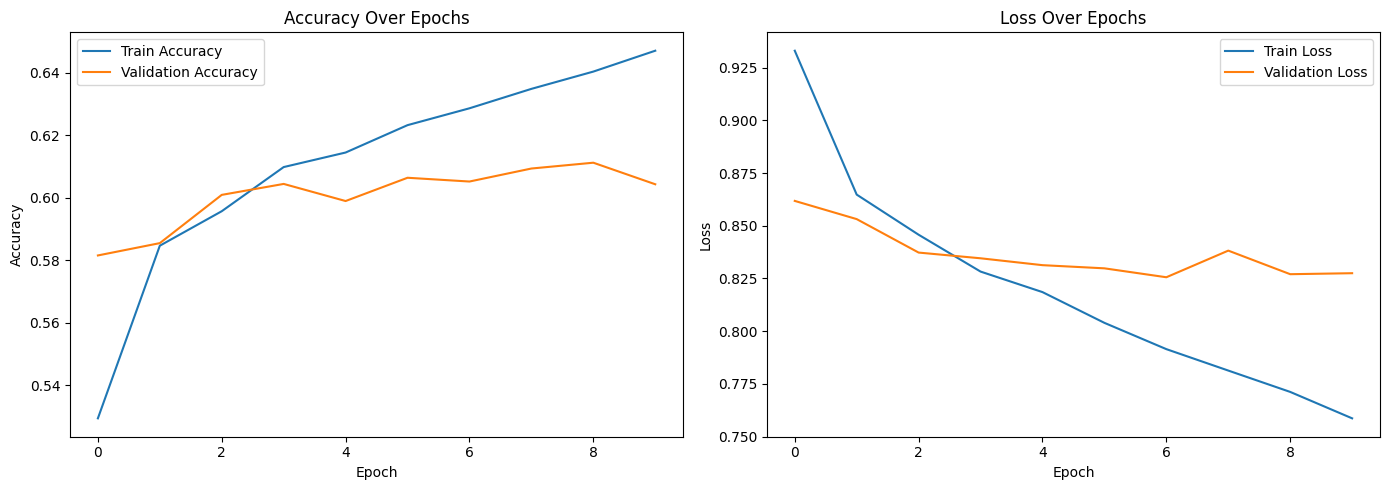

384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


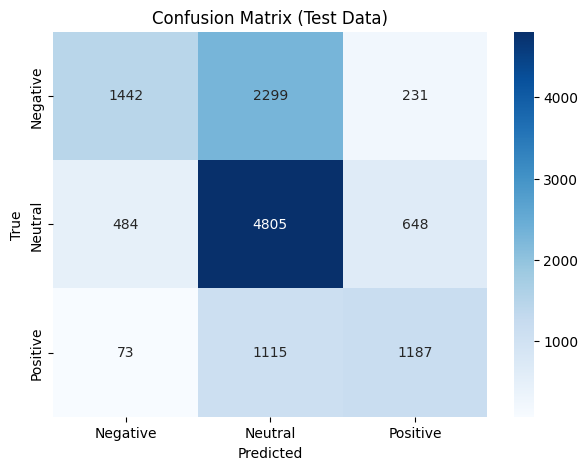

Classification Report on Test Data:
              precision    recall  f1-score   support

    Negative     0.7214    0.3630    0.4830      3972
     Neutral     0.5846    0.8093    0.6789      5937
    Positive     0.5745    0.4998    0.5346      2375

    accuracy                         0.6052     12284
   macro avg     0.6268    0.5574    0.5655     12284
weighted avg     0.6269    0.6052    0.5876     12284



In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_rnn_glove.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn_glove.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn_glove.history['loss'], label='Train Loss')
plt.plot(history_rnn_glove.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_model(rnn_model_glove, X_test_pad, y_test_cat)  # <-- evaluate on test


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the LSTM model
lstm_model_glove = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,  # Adjust based on your padding length
              weights=[embedding_matrix],  # Use GloVe embeddings
              trainable=False),  # Optionally freeze the embeddings
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 sentiment classes
])

# Compile the model
lstm_model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model_glove.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
history_lstm_glove = lstm_model_glove.fit(
    X_train_pad, y_train_cat,
    epochs=12,
    batch_size=64,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1
)


Epoch 1/12
571/571 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.5364 - loss: 0.9288 - val_accuracy: 0.6114 - val_loss: 0.8217
Epoch 2/12
571/571 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.6188 - loss: 0.8091 - val_accuracy: 0.6179 - val_loss: 0.8063
Epoch 3/12
571/571 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.6443 - loss: 0.7777 - val_accuracy: 0.6290 - val_loss: 0.7815
Epoch 4/12
571/571 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.6528 - loss: 0.7630 - val_accuracy: 0.6407 - val_loss: 0.7794
Epoch 5/12
571/571 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.6677 - loss: 0.7346 - val_accuracy: 0.6313 - val_loss: 0.7776
Epoch 6/12
571/571 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.6793 - loss: 0.7099 - val_accuracy: 0.6412 - val_loss: 0.7816
Epoch 7/12
571/571 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6904 - loss: 0.6905 - val_accuracy: 0.6426 - val_loss: 0.7808
Epoch 8/12
571/571 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.7042 - loss: 0.6644 - 

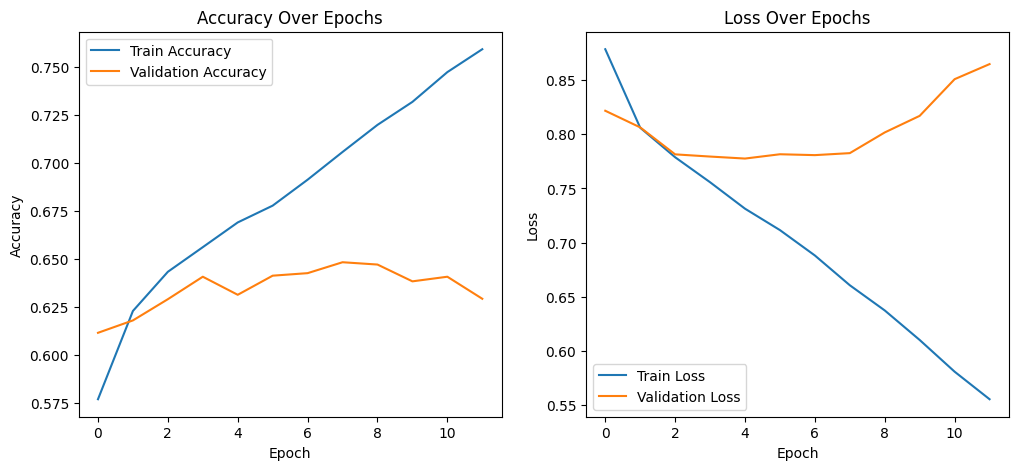

In [ ]:
# Plotting Training Curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_lstm_glove.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_glove.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_lstm_glove.history['loss'], label='Train Loss')
plt.plot(history_lstm_glove.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


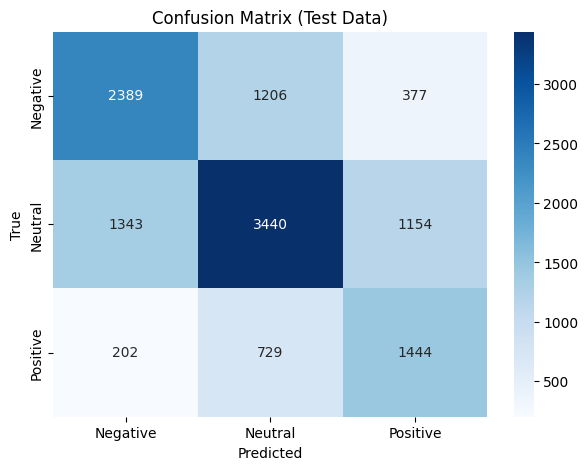

Classification Report on Test Data:
              precision    recall  f1-score   support

    Negative     0.6073    0.6015    0.6044      3972
     Neutral     0.6400    0.5794    0.6082      5937
    Positive     0.4854    0.6080    0.5398      2375

    accuracy                         0.5921     12284
   macro avg     0.5775    0.5963    0.5841     12284
weighted avg     0.5995    0.5921    0.5937     12284



In [ ]:
test_model(lstm_model_glove, X_test_pad, y_test_cat)  # <-- evaluate on test